In [1]:
# Cell 1 — Imports & plotting defaults
import pandas as pd
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Plotly (interactive)
try:
    import plotly.graph_objects as go
    import plotly.express as px
    PLOTLY = True
except:
    PLOTLY = False

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (14,5)
sns.set_context("notebook")


In [14]:
# Cell 2 — Load GOLD file
DATA_PATH = Path("Data/GOLD_FUT.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Place GOLD_FUT.csv in Data/ folder.")

df = pd.read_csv(DATA_PATH, dtype=str)
df.columns = [c.strip() for c in df.columns]

# Normalize spacing & robust datetime parse
df['datetime_raw'] = df['datetime'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
df['datetime'] = pd.to_datetime(df['datetime_raw'], dayfirst=True, errors='coerce')

# Numeric conversions
for col in ['open','high','low','close','volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Loaded rows:", len(df))
print("Datetime parse errors:", df['datetime'].isna().sum())
df.head(5)


Loaded rows: 547532
Datetime parse errors: 332585


,datetime,tradingsymbol,expiry,open,high,low,close,volume,datetime_raw
0,2021-01-07 09:00:00,GOLD21AUGFUT,2021-08-05,46930.0,47001.0,46930.0,46984.0,42.0,2021-07-01 09:00:00
1,2021-01-07 09:01:00,GOLD21AUGFUT,2021-08-05,46984.0,46984.0,46975.0,46978.0,33.0,2021-07-01 09:01:00
2,2021-01-07 09:02:00,GOLD21AUGFUT,2021-08-05,46978.0,46980.0,46973.0,46980.0,15.0,2021-07-01 09:02:00
3,2021-01-07 09:03:00,GOLD21AUGFUT,2021-08-05,46980.0,46982.0,46976.0,46980.0,15.0,2021-07-01 09:03:00
4,2021-01-07 09:04:00,GOLD21AUGFUT,2021-08-05,46980.0,46983.0,46979.0,46979.0,13.0,2021-07-01 09:04:00


In [3]:
# Cell 3 — Extract EOD ticks (last tick before midnight)
EOD_CUTOFF = "23:59"

df = df.dropna(subset=['datetime']).copy()
df['sec_of_day'] = df['datetime'].dt.hour*3600 + df['datetime'].dt.minute*60 + df['datetime'].dt.second
df['cal_date'] = df['datetime'].dt.date

hh, mm = map(int, EOD_CUTOFF.split(':'))
cutoff_sec = hh*3600 + mm*60

df['market_date'] = pd.to_datetime(df['cal_date'])
after_mask = df['sec_of_day'] > cutoff_sec
df.loc[after_mask, 'market_date'] = df.loc[after_mask, 'market_date'] + pd.Timedelta(days=1)

df['eod_cutoff_ts'] = df['market_date'] + pd.to_timedelta(f"{EOD_CUTOFF}:00")
valid = df[df['datetime'] <= df['eod_cutoff_ts']].copy()

idx = valid.groupby('market_date')['datetime'].idxmax()
eod = valid.loc[idx, ['market_date','open','high','low','close','volume']].copy()
eod['date'] = eod['market_date'].dt.date
eod = eod.sort_values('date').reset_index(drop=True)

print("EOD rows:", len(eod))
eod.head()


EOD rows: 261


,market_date,open,high,low,close,volume,date
0,2021-01-07,47030.0,47030.0,47003.0,47012.0,19.0,2021-01-07
1,2021-01-09,47075.0,47090.0,47062.0,47090.0,11.0,2021-01-09
2,2021-01-10,46283.0,46283.0,46283.0,46283.0,0.0,2021-01-10
3,2021-01-11,47885.0,47910.0,47869.0,47869.0,12.0,2021-01-11
4,2021-01-12,47783.0,47783.0,47783.0,47783.0,0.0,2021-01-12


In [4]:
# Cell 4 — Daily series
series = eod.copy()
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date').asfreq('D')

for col in ['open','high','low','close']:
    series[col] = pd.to_numeric(series[col], errors='coerce').ffill()

series['volume'] = pd.to_numeric(series['volume'], errors='coerce').fillna(0)

# Moving averages, Bollinger
series['ma20'] = series['close'].rolling(20).mean()
series['std20'] = series['close'].rolling(20).std()
series['bb_up'] = series['ma20'] + 2*series['std20']
series['bb_dn'] = series['ma20'] - 2*series['std20']

# RSI
delta = series['close'].diff()
roll_up = delta.clip(lower=0).ewm(alpha=1/14, adjust=False).mean()
roll_down = (-delta.clip(upper=0)).ewm(alpha=1/14, adjust=False).mean()
rs = roll_up / roll_down
series['rsi'] = 100 - (100/(1+rs))

# MACD
ema12 = series['close'].ewm(span=12, adjust=False).mean()
ema26 = series['close'].ewm(span=26, adjust=False).mean()
series['macd'] = ema12 - ema26
series['signal'] = series['macd'].ewm(span=9, adjust=False).mean()
series['macd_hist'] = series['macd'] - series['signal']

# Returns + volatility
series['returns'] = series['close'].pct_change()
series['vol_14'] = series['returns'].rolling(14).std() * np.sqrt(252)

series.tail(6)


,market_date,open,high,low,close,volume,ma20,std20,bb_up,bb_dn,rsi,macd,signal,macd_hist,returns,vol_14
date,,,,,,,,,,,,,,,,
2025-01-27,NaT,76893.0,76893.0,76893.0,76893.0,0.0,76893.0,0.000000,76893.00000,76893.00000,49.464493,-4.224784,9.999586,-14.224370,0.000000,0.000000
2025-01-28,NaT,76893.0,76893.0,76893.0,76893.0,0.0,76893.0,0.000000,76893.00000,76893.00000,49.464493,-4.698704,7.059928,-11.758632,0.000000,0.000000
2025-01-29,NaT,76893.0,76893.0,76893.0,76893.0,0.0,76893.0,0.000000,76893.00000,76893.00000,49.464493,-5.016461,4.644650,-9.661111,0.000000,0.000000
2025-01-30,NaT,76893.0,76893.0,76893.0,76893.0,0.0,76893.0,0.000000,76893.00000,76893.00000,49.464493,-5.208249,2.674070,-7.882319,0.000000,0.000000
2025-01-31,NaT,76893.0,76893.0,76893.0,76893.0,0.0,76893.0,0.000000,76893.00000,76893.00000,49.464493,-5.299157,1.079425,-6.378582,0.000000,0.000000
2025-02-01,2025-02-01,77719.0,77719.0,77690.0,77719.0,5.0,76934.3,184.699215,77303.69843,76564.90157,78.864432,60.581746,12.979889,47.601857,0.010742,0.045575


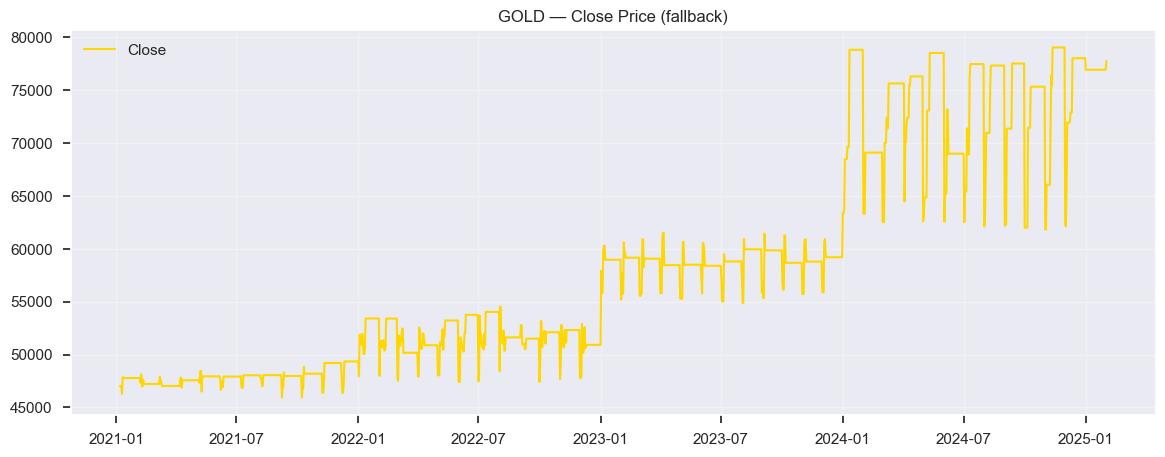

In [5]:
# Cell 5 — Candlestick chart
if PLOTLY:
    fig = go.Figure(data=[go.Candlestick(
        x=series.index,
        open=series['open'],
        high=series['high'],
        low=series['low'],
        close=series['close'],
        name='Gold OHLC'
    )])
    fig.update_layout(
        title='GOLD — Daily Candlestick Chart',
        xaxis_title='Date',
        yaxis_title='Price',
        height=600
    )
    fig.show()
else:
    plt.figure(figsize=(14,5))
    plt.plot(series.index, series['close'], label='Close', color='gold')
    plt.title('GOLD — Close Price (fallback)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


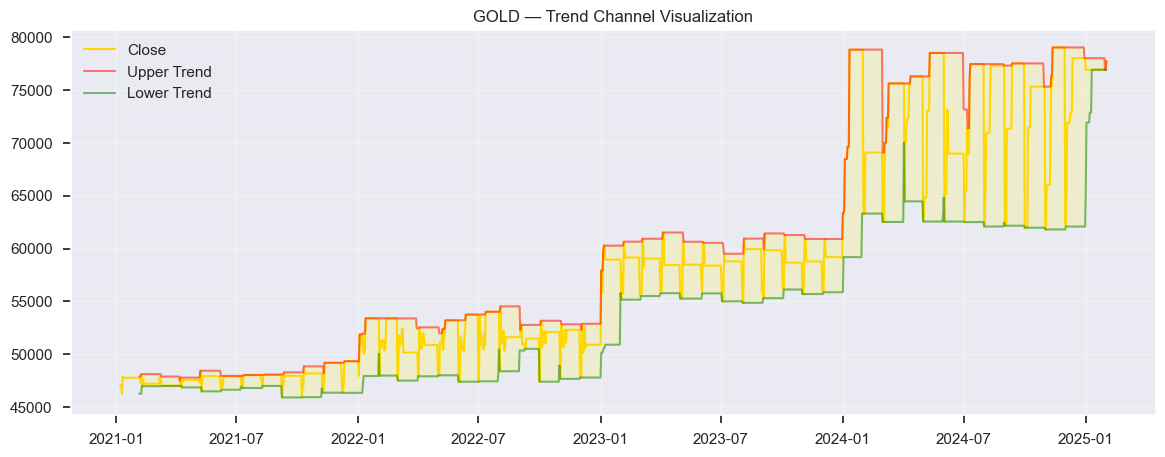

In [6]:
# Cell 6 — Trend channel computation
series_nonan = series.dropna(subset=['close'])
x = np.arange(len(series_nonan))
y = series_nonan['close'].values

# Upper & lower envelopes using rolling max/min smoothed
upper_env = series_nonan['high'].rolling(30).max()
lower_env = series_nonan['low'].rolling(30).min()

plt.figure(figsize=(14,5))
plt.plot(series_nonan.index, y, label="Close", color='gold')
plt.plot(series_nonan.index, upper_env, label="Upper Trend", color='red', alpha=0.5)
plt.plot(series_nonan.index, lower_env, label="Lower Trend", color='green', alpha=0.5)
plt.fill_between(series_nonan.index, lower_env, upper_env, color='yellow', alpha=0.15)
plt.title("GOLD — Trend Channel Visualization")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


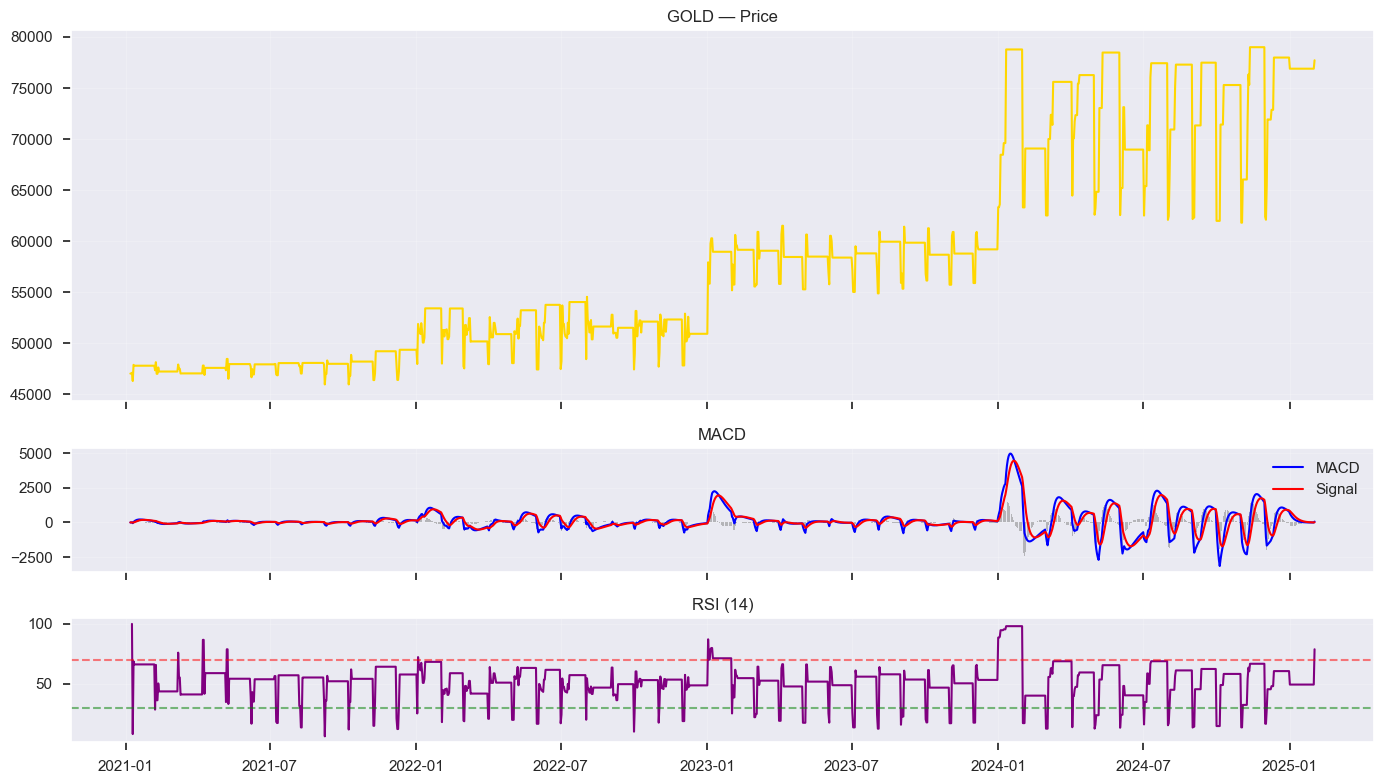

In [7]:
# Cell 7 — MACD + RSI panels
fig, axes = plt.subplots(3,1, figsize=(14,8), sharex=True, gridspec_kw={'height_ratios':[3,1,1]})

axes[0].plot(series.index, series['close'], color='gold')
axes[0].set_title('GOLD — Price')
axes[0].grid(alpha=0.2)

axes[1].bar(series.index, series['macd_hist'], color='gray', alpha=0.5)
axes[1].plot(series.index, series['macd'], color='blue', label='MACD')
axes[1].plot(series.index, series['signal'], color='red', label='Signal')
axes[1].legend()
axes[1].set_title('MACD')
axes[1].grid(alpha=0.2)

axes[2].plot(series.index, series['rsi'], color='purple')
axes[2].axhline(70, color='red', linestyle='--', alpha=0.5)
axes[2].axhline(30, color='green', linestyle='--', alpha=0.5)
axes[2].set_title('RSI (14)')
axes[2].grid(alpha=0.2)

plt.tight_layout()
plt.show()


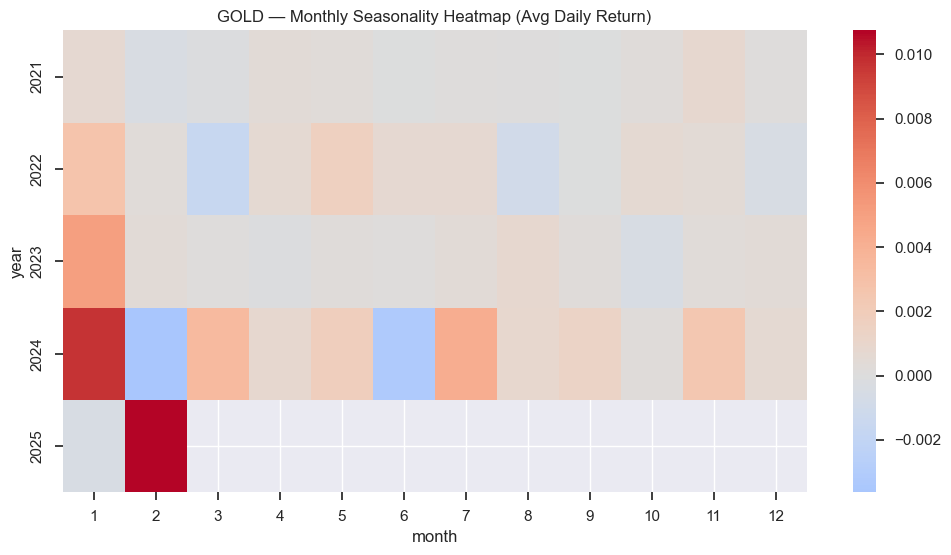

In [8]:
# Cell 8 — Monthly seasonality
dfm = series[['returns']].dropna().copy()
dfm['year'] = dfm.index.year
dfm['month'] = dfm.index.month
pivot = dfm.pivot_table(values='returns', index='year', columns='month', aggfunc='mean')

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='coolwarm', center=0, annot=False)
plt.title("GOLD — Monthly Seasonality Heatmap (Avg Daily Return)")
plt.show()


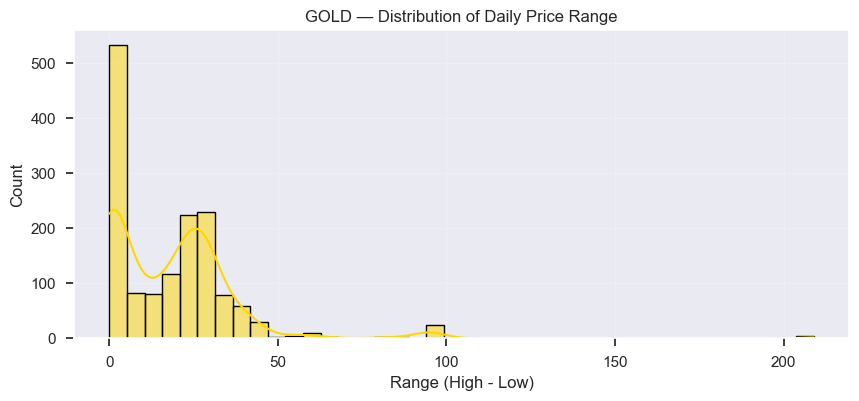

In [9]:
# Cell 9 — Daily range distribution
series['range'] = series['high'] - series['low']

plt.figure(figsize=(10,4))
sns.histplot(series['range'].dropna(), bins=40, kde=True, color='gold')
plt.title("GOLD — Distribution of Daily Price Range")
plt.xlabel("Range (High - Low)")
plt.grid(alpha=0.2)
plt.show()


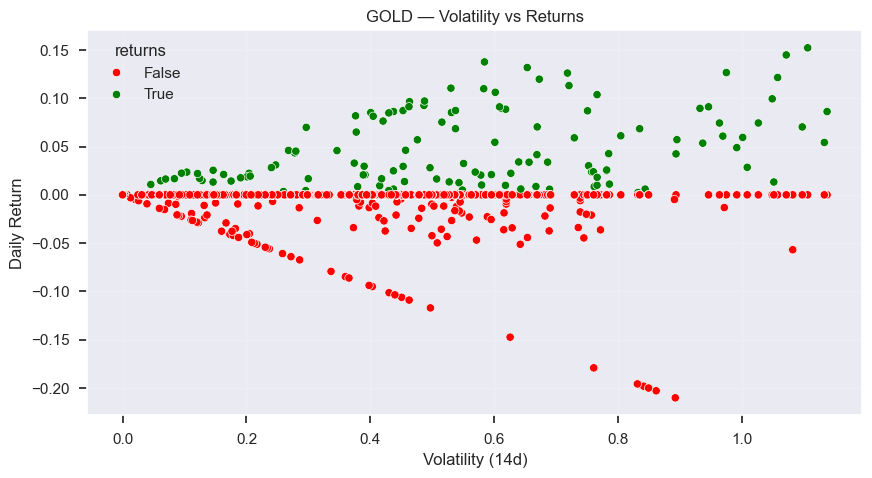

In [10]:
# Cell 10 — Vol vs Return scatter
plt.figure(figsize=(10,5))
sns.scatterplot(x=series['vol_14'], y=series['returns'], hue=series['returns']>0, palette=['red','green'])
plt.title("GOLD — Volatility vs Returns")
plt.xlabel("Volatility (14d)")
plt.ylabel("Daily Return")
plt.grid(alpha=0.2)
plt.show()


In [11]:
# Cell 11 — Summary metrics
latest = series['close'].dropna().iloc[-1]
chg = (series['close'].dropna().iloc[-1] / series['close'].dropna().iloc[0] - 1) * 100
vol = series['vol_14'].dropna().iloc[-1]

print("GOLD Snapshot:")
print("Latest Price:", round(latest,2))
print("Cumulative Change:", f"{chg:.2f}%")
print("Recent Volatility (14d, annualized):", round(vol,3))


GOLD Snapshot:
Latest Price: 77719.0
Cumulative Change: 65.32%
Recent Volatility (14d, annualized): 0.046


In [12]:
# Cell 12 — Small baseline model (optional)
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    df_tab = series[['close']].copy().reset_index().rename(columns={'index':'date'})
    for lag in range(1,6):
        df_tab[f'lag_{lag}'] = df_tab['close'].shift(lag)
    df_tab = df_tab.dropna().reset_index(drop=True)

    X = df_tab[[f'lag_{l}' for l in range(1,6)]].values
    y = df_tab['close'].shift(-1).ffill().values

    if len(X) < 50:
        print("Not enough rows for baseline; skipping.")
    else:
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        rmse = (mean_squared_error(y_test, preds))**0.5
        print("Baseline MAE:", round(mae,2))
        print("Baseline RMSE:", round(rmse,2))
except Exception as e:
    print("Baseline skipped:", e)


Baseline MAE: 2198.26
Baseline RMSE: 3703.71


In [13]:
# Cell 13 — Export instructions
print("GOLD showcase notebook ready.")
print("Export to HTML for your website using:")
print("jupyter nbconvert --to html GOLD_showcase.ipynb --output public/notebooks/gold_showcase.html")


GOLD showcase notebook ready.
Export to HTML for your website using:
jupyter nbconvert --to html GOLD_showcase.ipynb --output public/notebooks/gold_showcase.html
